# MDPs in TensorFlow - Navigation with Additive Noise

In this IPython notebook, we'll explore how to model in TensorFlow a **Continuous State-Action MDP** with stochastic transitions defined by additive noise, i.e.:

$$
\begin{align}
\mathbf{s}_{t+1} &= \mathcal{T}(\mathbf{s}_t, \mathbf{a}_{t+1}) + \xi \\
\xi &\sim p(\cdot; \mathbf{s}_t, \mathbf{a}_{t+1})
\end{align}
$$

where $\xi$ is a continuos random variable distributed as the probability density function $p(\xi; \mathbf{s}_t, \mathbf{a}_{t+1})$.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import abc
import functools
import time

import utils

%matplotlib inline

## Modeling MDPs in TensorFlow

All classes defining MDPs must inherit from abstract class ```MDP```.

In [2]:
class MDP(metaclass=abc.ABCMeta):
    
    @abc.abstractproperty
    def action_size(self):
        return
    
    @abc.abstractproperty
    def state_size(self):
        return

    @abc.abstractmethod
    def transition(self, state, action, noise=None):
        return

    @abc.abstractmethod
    def reward(self, state, action):
        return


### Navigation in 2D grid with deceleration zone at the center

In [3]:
class Navigation(MDP):

    def __init__(self, graph, grid, deceleration):
        self.graph = graph

        self.ndim = grid["ndim"]

        with self.graph.as_default():

            # grid constants
            self.__size = tf.constant(grid["size"], dtype=tf.float32)
            self.__goal = tf.constant(grid["goal"], dtype=tf.float32)

            # deceleration constants
            self.__center = tf.constant(deceleration["center"], dtype=tf.float32)
            self.__decay  = tf.constant(deceleration["decay"],  dtype=tf.float32)

            # numerical constants
            self.__0_00 = tf.constant(0.00, dtype=tf.float32)
            self.__1_00 = tf.constant(1.00, dtype=tf.float32)
            self.__2_00 = tf.constant(2.00, dtype=tf.float32)

    @property
    def action_size(self):
        return self.ndim
    
    @property
    def state_size(self):
        return self.ndim
        
    def transition(self, state, action):

        with self.graph.as_default():

            # distance to center of deceleration zone
            d = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center), axis=1, keep_dims=True))

            # deceleration_factor
            deceleration = self.__2_00 / (self.__1_00 + tf.exp(-self.__decay * d)) - self.__1_00

            # deterministic next position
            p = state + deceleration * action

            # noise (with reparameterization trick)
            noise = tf.distributions.Normal(loc=p, scale=0.2)

            # next state
            next_state = noise.sample()

            # avoid getting out of map
            next_state = tf.clip_by_value(next_state, self.__0_00, self.__size)

        return next_state, noise.log_prob(next_state)

    def reward(self, state, action):

        with self.graph.as_default():

            # norm L-2 (euclidean distance)
            r = -tf.sqrt(tf.reduce_sum(tf.square(state - self.__goal), axis=1, keep_dims=True))

        return r

## Encoding an MDP as a Recurrent Neural Net

### Encapsulate MDP components into RNN cell

In [4]:
class MDP_RNNCell(tf.nn.rnn_cell.RNNCell):

    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy

    @property
    def action_size(self):
        return self.mdp.action_size
        
    @property
    def state_size(self):
        return self.mdp.state_size * 2

    @property
    def output_size(self):
        return self.mdp.state_size + self.mdp.action_size + 1

    def __call__(self, inputs, state, scope=None):

        # timestep
        timestep = inputs
        
        # separate state and the history likelihood
        state = tf.unstack(state, axis=1)
        state, likelihood = state[:self.state_size//2], state[self.state_size//2:]
        state = tf.stack(state, axis=1)
        likelihood = tf.stack(likelihood, axis=1)
        
        with self.mdp.graph.as_default():

            # augment state by adding timestep to state vector
            state_t = tf.concat([state, timestep], axis=1)

            # add policy network with augmented state as input
            action = self.policy(state_t)

            # add MDP components to the RNN cell output
            next_state, log_prob = self.mdp.transition(state, action)
            reward = self.mdp.reward(next_state, action)
            
            # combine rewards and likelihood for surrogate loss function
            likelihood += log_prob
            # reward += likelihood * reward

            # concatenate outputs
            outputs = tf.concat([reward, next_state, action], axis=1)

            # concatenate togeter next state and updated likelihood of history so far
            next_state = tf.concat([next_state, likelihood], axis=1)
            
        return outputs, next_state

### Define the MDP's policy as a Multi-Layer Perceptron (MLP)

In [5]:
class PolicyNetwork(object):
    
    def __init__(self, graph, layers, limits=1.0):
        self.graph = graph
        self.policy = functools.partial(self.__build_network, layers, limits)
    
    def __call__(self, state):
        return self.policy(state)
    
    def __build_network(self, layers, limits, state):

        with self.graph.as_default():

            with tf.variable_scope('policy'):

                # hidden layers
                outputs = state
                for i, n_h in enumerate(layers[1:]):
                    if i != len(layers)-2:
                        activation = tf.nn.relu
                    else:
                        activation = tf.nn.tanh

                    outputs = tf.layers.dense(outputs,
                                              units=n_h,
                                              activation=activation,
                                              kernel_initializer=tf.glorot_normal_initializer(),
                                              name="layer"+str(i+1))

                # add action limits over last tanh layer
                action = tf.constant(limits) * outputs

        return action

## Unroll the model given a finite horizon

In [6]:
class MDP_RNN(object):
    
    def __init__(self, mdp, policy, batch_size=1):
        self.cell = MDP_RNNCell(mdp, policy)
        self.graph = mdp.graph
    
    def unroll(self, initial_state, timesteps):

        inputs = timesteps

        max_time = int(inputs.shape[1])
        state_size = self.cell.state_size // 2

        with self.graph.as_default():
            
            # timesteps
            inputs = tf.placeholder_with_default(tf.constant(timesteps, name='timesteps'),
                                                 shape=(None, max_time, 1),
                                                 name='inputs')
            # initial cell state
            initial_state = tf.placeholder_with_default(tf.constant(initial_state),
                                                        shape=(None, self.cell.state_size),
                                                        name='initial_state')

            # dynamic time unrolling
            outputs, final_state = tf.nn.dynamic_rnn(
                self.cell,
                inputs,
                initial_state=initial_state,
                dtype=tf.float32)

            # gather reward, state and action series
            outputs = tf.unstack(outputs, axis=2)
            reward_series = tf.reshape(outputs[0], [-1, max_time, 1])
            state_series  = tf.stack(outputs[1:1+state_size], axis=2)
            action_series = tf.stack(outputs[1+state_size:],  axis=2)
        
        return reward_series, state_series, action_series, final_state

## Define the Policy Optimizer

In [7]:
class PolicyOptimizer(object):
    
    def __init__(self, graph, loss, total, learning_rate):
        self.graph = graph

        # performance metrics
        self.loss = loss
        self.total = total

        # optimization hyperparameters
        self.learning_rate = learning_rate

        with self.graph.as_default():

            # backprop via RMSProp
            self.train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

            # global initializer
            self.init_op = tf.global_variables_initializer()

    def run(self, sess, epoch=100, show_progress=True):
        
        # initialize variables
        sess.run(self.init_op)
        
        losses = []
        totals = []
        for epoch_idx in range(epoch):

            # backprop and update weights
            _, loss, total = sess.run([self.train_step, self.loss, self.total])

            # store total reward
            total = np.mean(total)
            totals.append(total)

            # store loss information
            losses.append(loss)

            # show information
            if show_progress:
                print('Epoch {0:5}: loss = {1}\r'.format(epoch_idx, loss, total), end='')
        print()

        return losses, totals

## Define the loss function

In [8]:
def MSE_loss_function(graph, rewards):
    
    with graph.as_default():
        total = tf.reduce_sum(rewards, axis=1)
        loss  = tf.reduce_mean(tf.square(total))
    
    return total, loss

## Train the Policy Network

In [9]:
def train(graph, optimizer, epoch):

    # saver
    with graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=graph) as sess:

        start = time.time()

        # optimize it, babe!
        losses, totals = optimizer.run(sess, epoch)

        end = time.time()
        uptime = end - start
        print("Done in {0:.6f} sec.\n".format(uptime))

        # save model
        save_path = saver.save(sess, 'models/model.ckpt')
        print("Model saved in file: %s" % save_path)

    return losses, totals, saver, uptime

## Simulate 

In [10]:
def simulate(graph, series, initial_state, timesteps):
    with graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=graph) as sess:
        # restore learned policy model
        saver.restore(sess, 'models/model.ckpt')

        # simulate MDP trajectories
        result = sess.run(series, feed_dict={'inputs:0': timesteps, 'initial_state:0': initial_state})

    return result

## Define the RNN inputs for all batches

In [11]:
def build_initial_state(x0, y0, batch_size):
    x_init = np.full([batch_size], x0, np.float32)
    y_init = np.full([batch_size], y0, np.float32)
    position_init   = np.stack([x_init, y_init], axis=1)
    likelihood_init = np.zeros_like(position_init)
    initial_state   = np.concatenate([position_init, likelihood_init], axis=1)
    return initial_state

def build_timesteps(batch_size, max_time):
    timesteps = [np.arange(start=1.0, stop=max_time + 1.0, dtype=np.float32)]
    timesteps = np.repeat(timesteps, batch_size, axis=0)
    timesteps = np.reshape(timesteps, (batch_size, max_time, 1))
    return timesteps

## Putting all together!

It's time to train our model! Let's first of all create the computational graph to which all necessary operations will be added.

In [12]:
# domain parameters
grid = {
    'ndim': 2,
    'size': (10.0, 10.0),
    'start': (1.0,  5.0),
    'goal':  (8.0,  5.0)
}

deceleration = {
    'center': (5.0, 5.0),
    'decay': 2.0
}

# hyperparameters
epoch = 200
learning_rate = 0.001
batch_size = 10
max_time = 9

graph = tf.Graph()

# MDP model
mdp = Navigation(graph, grid, deceleration)

# define policy network
layers = [mdp.state_size + 1, 20, 5, mdp.action_size]
policy = PolicyNetwork(graph, layers)

# RNN inputs
# timesteps
timesteps = build_timesteps(batch_size, max_time)

# initial state
x0, y0 = grid['start']
initial_state = build_initial_state(x0, y0, batch_size)

# unroll MDP model
rnn = MDP_RNN(mdp, policy, batch_size)
rewards, states, actions, final_state = rnn.unroll(initial_state, timesteps)

# loss function
total, loss = MSE_loss_function(graph, rewards)

# optimizer
optimizer = PolicyOptimizer(graph, loss, total, learning_rate)

# let's train the model!
losses, totals, saver, uptime = train(graph, optimizer, epoch)

Epoch   199: loss = 669.46612548828125
Done in 10.489935 sec.

Model saved in file: models/model.ckpt


Let's simulate the learned model!

In [13]:
# simulations
simulation_batch_size = 10000
simulation_max_time = 9
s0 = build_initial_state(x0, y0, simulation_batch_size)
timesteps = build_timesteps(simulation_batch_size, simulation_max_time)
_, _, _, total_cost = simulate(graph, [rewards, states, actions, total], s0, timesteps)
total_cost = np.mean(total_cost)
print('>> Average Total Cost = {}'.format(total_cost))

INFO:tensorflow:Restoring parameters from models/model.ckpt
>> Average Total Cost = -26.811847686767578


### Plot loss function and cost per batch

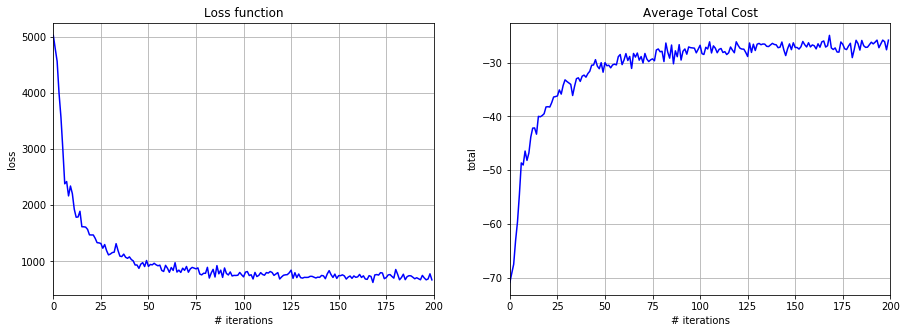

In [14]:
fig = plt.figure(figsize=(15, 5))

# plotting losses
ax = fig.add_subplot(121)
utils.plot_loss_function(ax, losses, epoch)

# histogram of cumulative cost per batch
ax = fig.add_subplot(122)
utils.plot_average_total_cost(ax, totals, epoch)

## Evaluate Policy

Let's evaluate the learned policy in an action grid for different timesteps.

In [15]:
def build_initial_states_grid(x_grid_size, y_grid_size, timestep):
    batch_size = x_grid_size * y_grid_size
    x_grid = np.linspace(0.0, grid['size'][0], x_grid_size)
    y_grid = np.linspace(0.0, grid['size'][1], y_grid_size)
    initial_states_grid = []
    for x in x_grid:
        for y in y_grid:
            initial_states_grid.append([x, y, timestep])
    return initial_states_grid, batch_size

In [16]:
def evaluate_policy(grid_size, state_size, timesteps):
    initial_states_grids = []
    actions = []
    
    graph = tf.Graph()
    with graph.as_default():
        
        # re-initialize initial_state placeholder
        batch_size = grid_size * grid_size
        initial_state = tf.placeholder(shape=(batch_size, state_size), dtype=np.float32, name='initial_state')

        # re-initialize policy
        with tf.variable_scope('rnn'):
            policy = PolicyNetwork(graph, layers)
            action = policy(initial_state)

        saver = tf.train.Saver()
        with tf.Session(graph=graph) as sess:
            saver.restore(sess, 'models/model.ckpt')
            
            for timestep in timesteps:

                # instantiate initial states in a grid 
                s0, batch_size = build_initial_states_grid(grid_size, grid_size, timestep)
                initial_states_grids.append(s0)

                # evaluate policy for given initial states
                a = sess.run(action, feed_dict={initial_state: s0})
                actions.append(a)
    
    return initial_states_grids, actions

INFO:tensorflow:Restoring parameters from models/model.ckpt


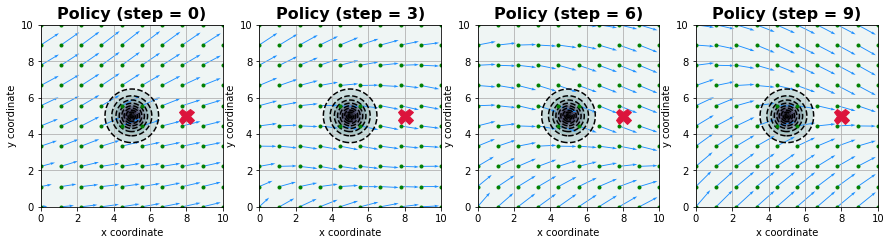

In [17]:
grid_size = 10
timesteps = np.array([0.0, max_time / 3, 2 / 3 * max_time, max_time], dtype=np.int32)
initial_states_grid, policy_actions = evaluate_policy(grid_size, mdp.state_size + 1, timesteps)

fig = plt.figure(figsize=(15, 5))
for i, timestep in enumerate(timesteps):
    ax = fig.add_subplot(1, len(timesteps), i+1)
    utils.plot_policy(ax, grid, deceleration, initial_states_grid[i], policy_actions[i], timestep)

## Simulate policy for different start states

In [18]:
batch_size = 3

# initial states for simulation
x0, y0 = grid['start']
delta_y = [0.0, -1.0, -1.5, 1.5, 1.0]
initial_states = []
for delta in delta_y:
    s0 = build_initial_state(x0, y0 + delta, batch_size)
    initial_states.append(s0)
initial_states = np.concatenate(initial_states, axis=0)

# total batch_size
batch_size = initial_states.shape[0]

# timestep
timesteps = build_timesteps(batch_size, max_time)

# simulate!
rewards, states, actions = simulate(graph, [rewards, states, actions], initial_states, timesteps)

INFO:tensorflow:Restoring parameters from models/model.ckpt


### Plot simulated trajectories

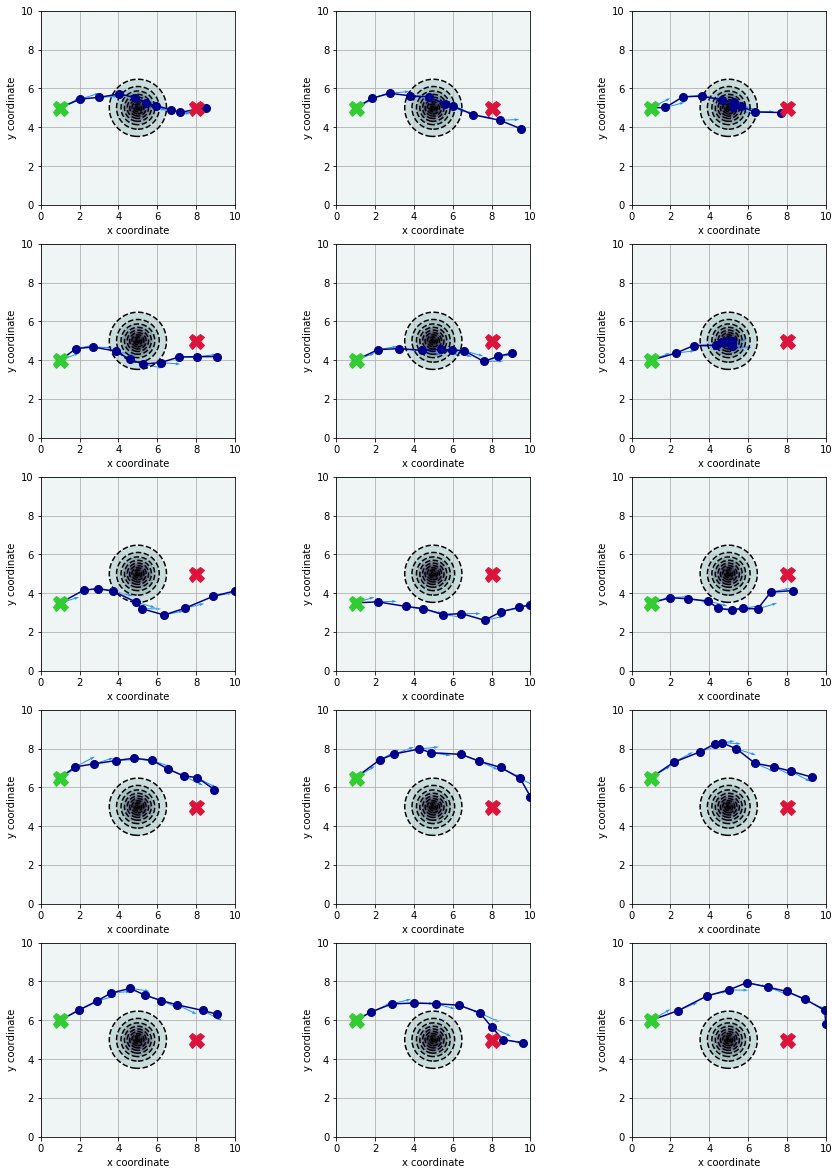

In [19]:
fig = plt.figure(figsize=(15, 25))
utils.plot_simulations(fig, grid, deceleration, initial_states, delta_y, states, actions)